# Introduction to Probabilistic Graphical Models 
# Practical Session 2 : EM for GMMs
##### Emma Demarecaux   emma.demarecaux@ensta-paris.fr

In [1]:
# Import Python modules
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import cm

## Question 1
In Gaussian Mixture Models, we often have to compute

$$ \gamma_i(x) = \frac{\pi_i\mathcal{N}(x;\mu_i,\Sigma_i)}{\sum_{j=1}^K \pi_j\mathcal{N}(x;\mu_j,\Sigma_j)}$$

where $x \in \mathbb{R}^d$ and $\pi_i \in [0,1]$.

Given $i \in [\![1;K]\!],\  \mathcal{N}(x;\mu_i,\Sigma_i)$ is close to $0$, and $\pi_i\mathcal{N}(x;\mu_i,\Sigma_i)$ is even smaller. At the end of the day, we end up with $\gamma_i(x) = \frac{0}{0}$ which is a NaN value. 

To implement a function for numerically stable computation of $\{\gamma_i\}_{i=1}^K$, we first take the logarithm : 

\begin{align}
\log \gamma_i(x) &= \log \pi_i\mathcal{N}(x;\mu_i,\Sigma_i) - \log \sum_{j=1}^K \pi_j\mathcal{N}(x;\mu_j,\Sigma_j)\\
&= l_i - \log \sum_{j=1}^K \exp l_j
\end{align}

with : 

$\forall i \in [\![1;K]\!]$ : $
\left\{
    \begin{array}{ll}
        l_i \equiv \log \pi_i\mathcal{N}(x;\mu_i,\Sigma_i)\\
        \mathcal{N}(x;\mu_i,\Sigma_i) = \frac{1}{\sqrt{(2\pi)^d \det \Sigma_i}}\exp\big[-\frac{1}{2}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i) \big]
    \end{array}
\right.
$

Therefore : 

\begin{align}
l_i &= \log \bigg[\pi_i\frac{1}{\sqrt{(2\pi)^d\det \Sigma_i}}\exp\big[-\frac{1}{2}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i) \big] \bigg]\\
&= \log \pi_i - \frac{d}{2} \log (2\pi) - \frac{1}{2} \log (\det \Sigma_i) -\frac{1}{2}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)
\end{align}

We need to be careful with the computation of $\log (\det \Sigma_i)$. If an array has a very small or very large determinant, then a call to $\texttt{numpy.linalg.det}$ may overflow or underflow. Instead of this function, we can use $\texttt{numpy.linalg.slogdet}$ which computes the logarithm of the determinant rather than the determinant itself. 

Then, we apply the $\texttt{log_sum_exp}$ trick :
let $l^* \equiv \max_{i \in [\![1;K]\!]} l_i$

\begin{align}
\log \sum_{j=1}^K \pi_j\mathcal{N}(x;\mu_j,\Sigma_j) 
&= \log \sum_{j=1}^K \exp l_j\\
&= \log\sum_{j=1}^K \exp\left(l_j - l^* + l^*\right) \\
&= \log\sum_{j=1}^K \exp\left(l_j - l^*\right)\exp\left(l^*\right) \\
&= \log\exp\left(l^*\right) + \log\sum_{j=1}^K \exp\left(l_j - l^*\right) \\
&= l^* + \log\sum_{j=1}^K \exp\left(l_j - l^*\right) \\
\end{align}

We have $\sum_{j=1}^K \exp\left(l_j - l^*\right) \geq 1$, therefore the whole expression is numerically stable.

In [2]:
def stable_log_sum_exp(l):
    # Compute the log-sum-exp trick
    l_max = np.max(l)
    return l_max + np.log(np.sum(np.exp(l - l_max)))

def log_l_vector(x, P, Mu, Sigma):
    # Dimension : K
    # Compute the vector L(x) with : for all i in {1,...,K} L(x)[i] = l𝑖(x) ≡ log 𝜋𝑖 N(𝑥;𝜇i,Σ𝑖)
    log_l_list = []
    for (p, mu, sigma) in zip(P, Mu, Sigma):
        log_l = np.log(p)
        log_l -= d * np.log(2*np.pi) / 2
        log_l -= (x-mu) @ np.linalg.inv(sigma) @ ((x-mu).T) / 2
        sign, log_det_sigma = np.linalg.slogdet(sigma)
        log_l -= log_det_sigma / 2
        log_l_list.append(log_l)
    return np.array(log_l_list)

def log_gamma_vector(x, P, Mu, Sigma):
    # Dimension : K
    # Compute the vector logΓ(x) with : for all i in {1,...,K} logΓ(x)[i] = log 𝛾𝑖(x)
    log_l = log_l_vector(x, P, Mu, Sigma)
    return log_l - stable_log_sum_exp(log_l)

## Question 2

#### Gaussian Mixture Model
Let us consider a set of observed data points $\{x_n\}_{n=1}^N$ where : $\forall n \in [\![1;N]\!]\ x_n \in \mathbb{R}^d$. 

Let us consider as well a Gaussian Mixture Model (GMM), given as follows :
$$P(X_n = x_n) = \sum_{i=1}^K\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)$$ 

Our unknown parameters are $\theta = \{\mu_1,...,\mu_K,\Sigma_1,...,\Sigma_K,\pi_1,...,\pi_K\}$. 

$\forall i \in [\![1;K]\!]$ :
$
\left\{
    \begin{array}{ll}
        \mu_i \in \mathbb{R}^d\\
        \Sigma_i \in \mathbb{R}^{d\textrm{x}d}\\
        \pi_i \in [0;1]\ \textrm{and}\ \sum_{i=1}^K\pi_i=1
    \end{array}
\right.
$

We wish to find $\theta$ such that $\forall n \in [\![1;N]\!],\ P(X_n = x_n;\theta)$ is a maximum. This is known as the Maximum Likelihood (ML) estimate for $\theta$. It is typical to introduce the log-likelihood function defined as :
$$L(\theta) = \log P(X_{1:N}=x_{1:N};\theta)$$

#### The EM algorithm
The EM algorithm attempts to find maximum likelihood estimates for models with latent variables when the ML estimator can't be analytically determined. We introduce $\{Z_n\}_{n \in [\![1;N]\!]}\in [\![1;K]\!]^N$, the latent variables
representing the mixture component for $\{X_n\}_{n \in [\![1;N]\!]}$. 

$\forall n \in [\![1;N]\!]$,
$$\log P(X_{n}=x_{n};\theta) = \log \sum_{z=1}^K P(X_n=x_n,Z_n=z;\theta )$$ 

We have :
\begin{align*}
\log P(X_{1:N}=x_{1:N},Z_{1:N};\theta ) &= \log P(X_{1:N}=x_{1:N}|Z_{1:N};\theta ) + \log P(Z_{1:N};\theta )\\
&= \log \prod_{n=1}^NP(X_n=x_{n}|Z_n;\theta ) + \log \prod_{n=1}^NP(Z_n;\theta )\\
&= \log \prod_{n=1}^N \prod_{i=1}^K \mathcal{N}(x_n;\mu_i,\Sigma_i)^{\mathbb{I}_{(Z_n = i)}}+ \log \prod_{n=1}^N \prod_{i=1}^K \pi_i^{\mathbb{I}_{(Z_n = i)}}\\
&= \sum_{n=1}^N \sum_{i=1}^K \mathbb{I}_{(Z_n = i)} \log \mathcal{N}(x_n;\mu_i,\Sigma_i)+ \sum_{n=1}^N \sum_{i=1}^K \mathbb{I}_{(Z_n = i)} \log \pi_i\\
&= \sum_{n=1}^N \sum_{i=1}^K \mathbb{I}_{(Z_n = i)} \log \pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)\\
\end{align*}

In practice, we do not observe the latent variables, so we consider the expectation of the complete log-likelihood with respect to the posterior of the latent variables.

The expected value of the complete log-likelihood is therefore:

\begin{align*}
\mathcal{L}(\theta) &= \mathbb{E}_{Z_{1:N}|X_{1:N}} \big[\log P(X_{1:N}=x_{1:N},Z_{1:N};\theta )\big]\\
&= \mathbb{E}_{Z_{1:N}|X_{1:N}}\big[\sum_{n=1}^N \sum_{i=1}^K \mathbb{I}_{(Z_n = i)} \log \pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)]\\
&= \sum_{n=1}^N \sum_{i=1}^K \mathbb{E}_{Z_{1:N}|X_{1:N}}\big[\mathbb{I}_{(Z_n = i)} \big]\log \pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)\\
&= \sum_{n=1}^N \sum_{i=1}^K P(Z_n=i|X_n=x_n;\theta)\log \pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i) \\
\end{align*}

The posterior distribution of $Z_n$ given the observations is :

\begin{align}
P(Z_n=i|X_n=x_n; \theta)
&= \frac{P(X_n=x_n|Z_n=i; \theta)P(Z_n=i; \theta)}{P(X_n=x_n; \theta)}\\
&= \frac{\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}{\sum_{j=1}^K \pi_j\mathcal{N}(x_n;\mu_j,\Sigma_j)}\\
&= \gamma_i(x_n)
\end{align}

Therefore :
$$\mathcal{L}(\theta) = \sum_{n=1}^N \sum_{i=1}^K \gamma_i(x_n)\log \pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)$$

The EM algorithm proceeds as follows: 
* **Initialization:** Choose initial values for $\theta_0$ and evaluate the log-likelihood with these parameters.
* At iteration $t$ :
    * **E-step:** Evaluate the posterior probabilities $\{\gamma_i^t(x_n)\}_{ n \in [\![1;N]\!],\ i \in [\![1;K]\!]}$ using the current values of $\theta_t$.
    * **M-step:** With $\{\gamma_i^t(x_n)\}_{n \in [\![1;N]\!],\ i \in [\![1;K]\!]}$ fixed, maximize the expected complete log-likelihood above with respect to $\theta_t$. This leads to the following closed form solutions : 

$\forall i \in [\![1;K]\!]$ : $
\left\{
    \begin{array}{ll}
        \gamma_i^t(x_n) = \frac{\pi_i^t\mathcal{N}(x_n;\mu_{i}^t,\Sigma_{i}^t)}{\sum_{j=1}^K \pi_j^t\mathcal{N}(x_n;\mu_{j}^t,\Sigma_{j}^t)} \\
        \mu_i^{t+1} = \frac{\sum_{n=1}^N \gamma_i^t(x_n)x_n}{\sum_{n=1}^N \gamma_i^t(x_n)}\\
        \Sigma_i^{t+1} = \frac{\sum_{n=1}^N \gamma_i^t(x_n)(x_n-\mu_i^{t+1})(x_n-\mu_i^{t+1})^T}{\sum_{n=1}^N \gamma_i^t(x_n)}\\
        \pi_i^{t+1} = \frac{1}{N}\sum_{n=1}^N \gamma_i^t(x_n)
    \end{array}
\right.
$


In [3]:
def gamma_matrix(X, P, Mu, Sigma):
    # Dimensions : K x N
    # Compute the matrix Γ with : for all n in {1,...,N} Γ[i,n] = 𝛾𝑖(xn)
    N = X.shape[0]
    log_gamma_list = []
    for n in range(N):
        log_gamma_list.append(log_gamma_vector(X[n,:], P, Mu, Sigma))
    return np.exp(np.array(log_gamma_list)).T

def M_Step_GMM(X, Gamma_matrix):
    # Compute the estimates for next iteration with Γ fixed
    N = X.shape[0]
    K = Gamma_matrix.shape[0]
    sum_gamma = Gamma_matrix @ np.ones([N,1])
    sum_gamma_X = Gamma_matrix @ X
    Mu_next = sum_gamma_X / sum_gamma
    P_next = Gamma_matrix.mean(axis=1)
    Sigma_next_list = []
    for i in range(K):
        Sigma_i_next = np.zeros([d,d])
        for n in range(N):
            diff_x_mu = (X[n,:] - Mu_next[i,:]).reshape(1,-1)
            Sigma_i_next += Gamma_matrix[i,n] * diff_x_mu.T @ diff_x_mu
        Sigma_next_list.append(Sigma_i_next / sum_gamma[i])    
    Sigma_next = np.array(Sigma_next_list)
    return P_next, Mu_next, Sigma_next

## Question 3

In [4]:
# Define parameters
N = 1000
K = 3
colors = ["orange", "magenta", "green"]
p1 = 0.3
p2 = 0.2
p3 = 0.5
mu1 = np.array([0.0,0.0])
mu2 = np.array([1.0,2.0])
mu3 = np.array([2.0,0.0])
sigma1 = np.array([[1.0,-0.25],[-0.25,0.50]])
sigma2 = np.array([[0.5,0.25],[0.25,0.5]])
sigma3 = np.array([[0.50,-0.25],[-0.25,1]])
d = mu1.shape[0]
P_true = np.array([p1,p2,p3])
Mu_true = np.array([mu1,mu2,mu3])
Sigma_true = np.array([sigma1, sigma2, sigma3])

### Task 1

In [5]:
def gen(N, P, Mu, Sigma):
    # Genrate a dataset
    d = Mu.shape[1]
    X = np.zeros([N,d])
    mixture_components = []
    for n in range(N):
        mixture_component = random.choices([0,1,2], P)[0]
        mixture_components.append(mixture_component)
        X[n,:] = np.random.multivariate_normal(Mu[mixture_component], Sigma[mixture_component])
    return X, np.array(mixture_components)

In [6]:
# Generation of the dataset
X, true_clusters = gen(N, P_true, Mu_true, Sigma_true)
true_labels = dict(enumerate(["Mixture Component " + str(i+1) for i in np.unique(true_clusters)]))

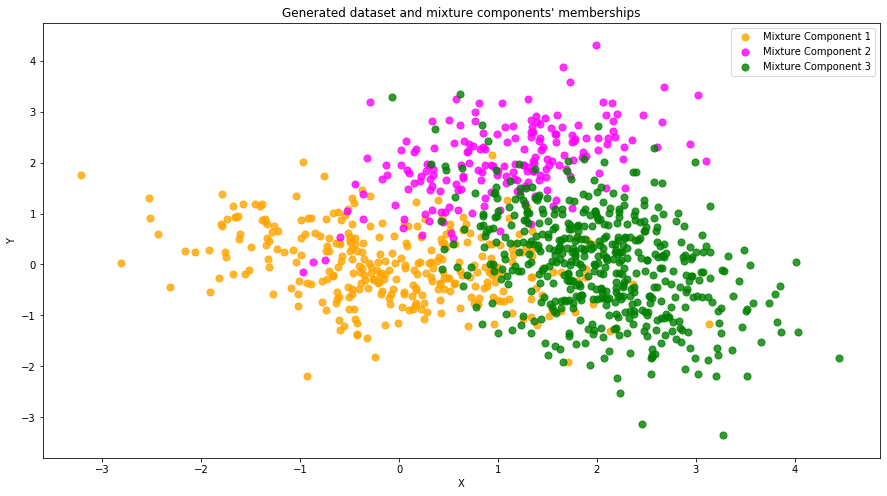

In [7]:
# Visualization of the dataset and the mixture components' memberships
plt.figure(figsize=(15,8))
for i in np.unique(true_clusters):
    true_mask = true_clusters == i
    plt.scatter(X[true_mask, 0], X[true_mask, 1], label=true_labels[i], s=50, alpha=0.8, c=colors[i])
plt.legend()
plt.title("Generated dataset and mixture components' memberships")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

##### **E-step:** Evaluate the posterior probabilities $\{\gamma_i(x_n)\}_{ n \in [\![1;N]\!],\ i \in [\![1;K]\!]}$ using the values of $\mu, \Sigma$ and $\pi$.

In [8]:
def order_clusters(clusters, X, Mu_true):
    K = len(np.unique(clusters))
    centroids = []
    for i in range(K):
        mask = clusters == i
        centroids.append(X[mask,:].mean(axis=0))
    clusters_ordered = []
    clusters_used = []
    for i in range(K):
        min_dist = np.inf
        ind = 0
        for j in range(K):
            dist = np.linalg.norm(Mu_true[j] - centroids[i],2)
            if (dist < min_dist) & (j not in clusters_used):
                min_dist = dist
                ind = j
        clusters_ordered.append(ind)
        clusters_used.append(ind)
    return clusters_ordered

In [9]:
def plot_clusters(X, Mu_true, true_clusters, clusters, title=""):
    ordered_clusters = order_clusters(clusters, X, Mu_true)
    labels = dict(enumerate(["Cluster " + str(i+1) for i in np.unique(ordered_clusters)]))
    true_labels = dict(enumerate(["Mixture Component " + str(i+1) for i in np.unique(true_clusters)]))
    
    for i in np.unique(true_clusters):
        if i < len(ordered_clusters):
            mask = clusters == i
            plt.scatter(X[mask, 0], X[mask, 1], label=labels[ordered_clusters[i]], s=50, alpha=0.8, 
                        c=colors[ordered_clusters[i]])
    
    for i in np.unique(true_clusters):
        true_mask = true_clusters == i
        plt.scatter(X[true_mask, 0], X[true_mask, 1], label=true_labels[i], s=30, alpha=0.8, marker='.', c=colors[i])
    
    plt.legend()
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")

In [10]:
# clusters' membership
clusters = gamma_matrix(X, P_true, Mu_true, Sigma_true).argmax(axis=0)

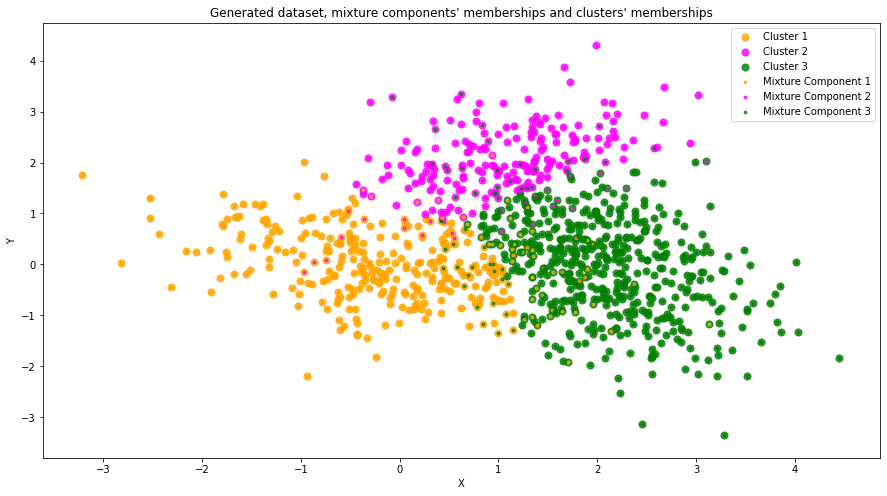

In [11]:
# Visualization of the dataset, the mixture components' memberships and the clusters' memberships
plt.figure(figsize=(15,8))
plot_clusters(X, Mu_true, true_clusters, clusters, "Generated dataset, mixture components' memberships and clusters' memberships")
plt.show()

### Task 2 

#### Variables and util functions

In [12]:
# Initial values which lead to valid results
P_init = np.ones(3)/K
Mu_init = np.array([
    [0.45886109, 0.18920361],
    [0.84762932, 0.21796953],
    [0.30223651, 0.66774731]
])
Sigma_init = np.array([
    [[0.53008701, 0.66461243],
     [0.01568535, 0.41753995]],
    [[0.69264691, 0.29862023],
     [0.08357958, 0.3298076 ]],
    [[0.73840699, 0.03643898],
     [0.40504823, 0.71899998]]
])

In [13]:
def initialization_GMM(K, X, random_init=True ,P_init=P_init, Mu_init=Mu_init, Sigma_init=Sigma_init):
    # Intialization of the EM Algorithm
    if random_init:
        d = X.shape[1]
        P = np.ones(3)/K
        # Take K points from X for the initialization of Mu
        index_centroids = random.sample([i for i in range(N)], K)
        Mu = X[index_centroids,:]
        Sigma = np.array([np.random.random([d,d]) for i in range(K)])
        return P, Mu, Sigma
    else:
        return P_init, Mu_init, Sigma_init

In [14]:
def log_likelihood(X, P, Mu, Sigma):
    res = 0
    for n in range(N):
        log_l = []
        for (p, mu, sigma) in zip(P, Mu, Sigma):
            log_l.append(log_l_vector(X[n,:], P, Mu, Sigma))
        res += stable_log_sum_exp(log_l)
    return res

In [15]:
def EM_GMM(nb_iterations, X, K, random_init=True):
    # EM algorithm
    d = X.shape[1]
    Ps = np.zeros([nb_iterations, K])
    Mus = np.zeros([nb_iterations, K, d])
    Sigmas = np.zeros([nb_iterations, K, d, d])
    Lls = np.zeros(nb_iterations)
    # Initialization
    P, Mu, Sigma = initialization_GMM(K, X, random_init)
    # Iterations
    for iteration in range(nb_iterations):
        # E-step : Compute the matrix Γ
        Gamma_matrix = gamma_matrix(X, P, Mu, Sigma)
        # M-step : Compute the new estimates
        P, Mu, Sigma = M_Step_GMM(X, Gamma_matrix)
        # Compute the log-likelihood
        Ll = log_likelihood(X, P, Mu, Sigma)
        # Store parameters at each iterations
        Ps[iteration] = P
        Mus[iteration] = Mu
        Sigmas[iteration] = Sigma
        Lls[iteration] = Ll
    return Ps, Mus, Sigmas, Lls      

In [16]:
def multivariate_gaussian(pos, mu, Sigma):
    # Multivariate gausssian for contour visualization
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return np.exp(-fac / 2) / N

In [17]:
def plot_gaussian_contours(X, Mu, Sigma):
    # Our 2-dimensional distribution will be over variables X
    X_linspace = np.linspace(min(X[:,0])-1, max(X[:,0])+1, N)
    Y_linspace = np.linspace(min(X[:,1])-1, max(X[:,1])+1, N)
    X_grid, Y_grid = np.meshgrid(X_linspace, Y_linspace)

    # Pack X_grid and Y_grid into a single 3-dimensional array
    pos = np.empty(X_grid.shape + (2,))
    pos[:, :, 0] = X_grid
    pos[:, :, 1] = Y_grid

    # The distribution on the variables X, Y packed into pos.
    M_gaussian = [multivariate_gaussian(pos, mu, sigma) for (mu, sigma) in zip(Mu, Sigma)]

    for i in range(K):
        plt.contour(X_grid, Y_grid, M_gaussian[i], cmap=cm.viridis)

#### EM algorithm with 50 iterations

In [18]:
nb_iterations = 50
Ps, Mus, Sigmas, Lls = EM_GMM(nb_iterations, X, K, random_init=False)

#### Visualizing the intermediate results by plotting the contours of the estimated Gaussians

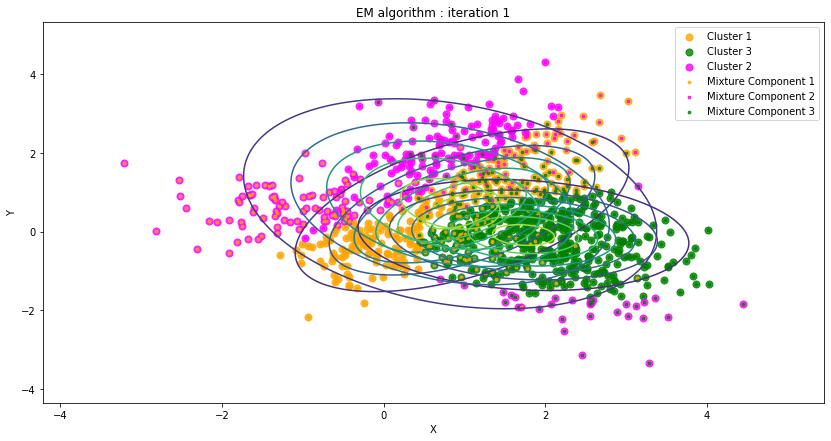

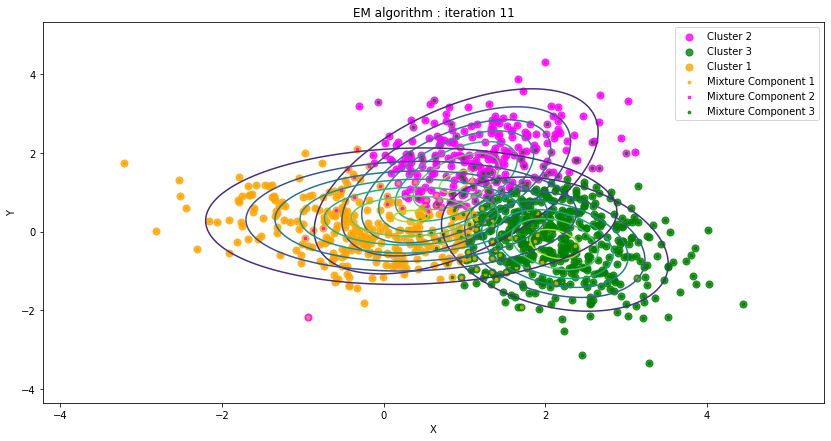

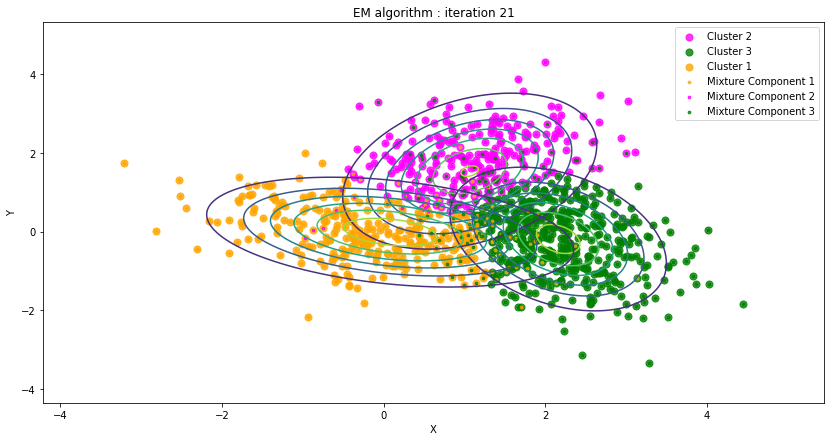

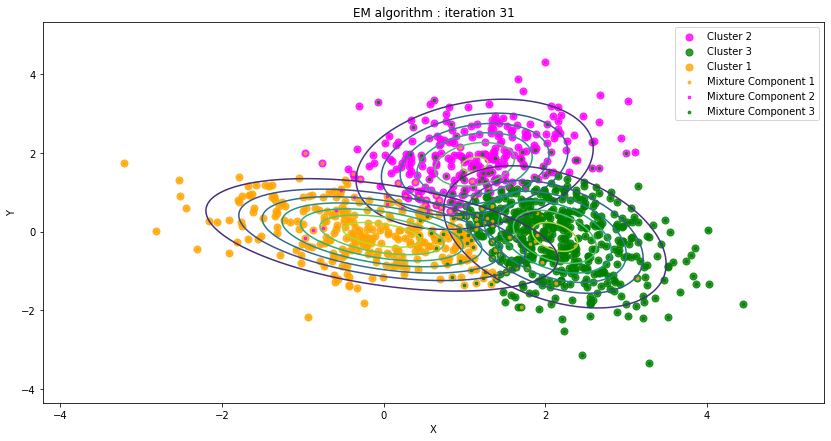

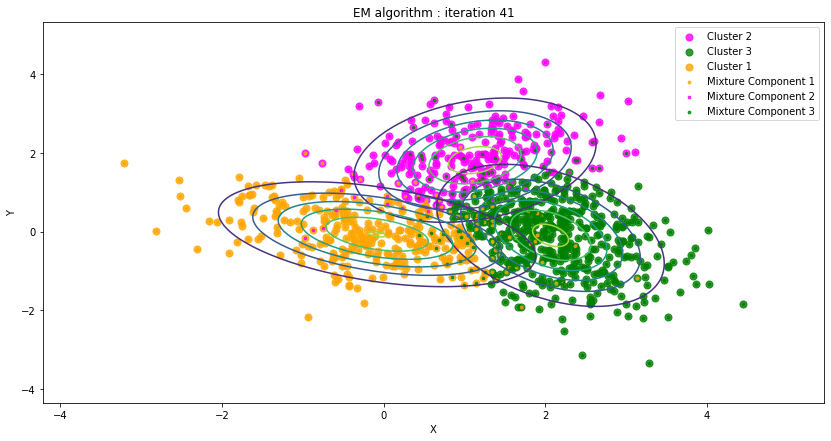

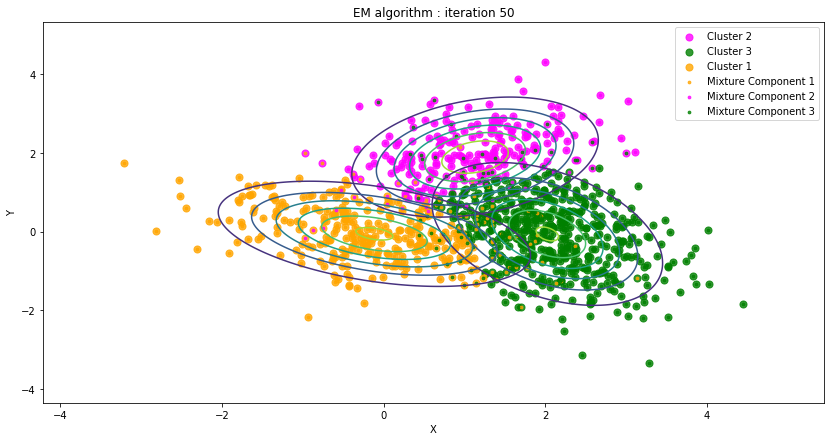

In [19]:
for i in range(5):
    P_est = Ps[i*10]
    Mu_est = Mus[i*10]
    Sigma_est = Sigmas[i*10]
    clusters = gamma_matrix(X, P_est, Mu_est, Sigma_est).argmax(axis=0)
    # Visualisation
    plt.figure(figsize=(14,7))
    plot_clusters(X, Mu_true, true_clusters, clusters, "EM algorithm : iteration " + str(i*10+1))
    plot_gaussian_contours(X, Mu_est, Sigma_est)
    plt.show()
P_est = Ps[nb_iterations-1]
Mu_est = Mus[nb_iterations-1]
Sigma_est = Sigmas[nb_iterations-1]
clusters = gamma_matrix(X, P_est, Mu_est, Sigma_est).argmax(axis=0)
# Visualisation
plt.figure(figsize=(14,7))
plot_clusters(X, Mu_true, true_clusters, clusters, "EM algorithm : iteration " + str(nb_iterations))
plot_gaussian_contours(X, Mu_est, Sigma_est)
plt.show()    

#### Log-likelihood vs iterations

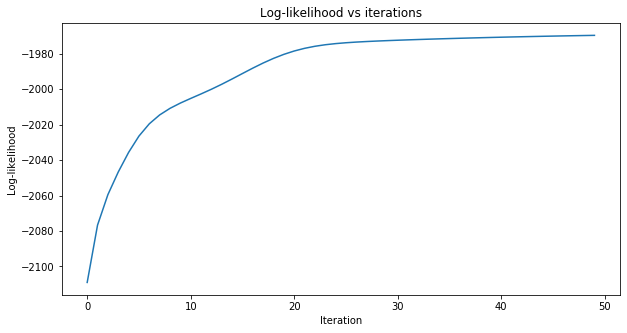

In [20]:
plt.figure(figsize=(10,5))
plt.plot(Lls)
plt.title("Log-likelihood vs iterations")
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.show()

The log-likelihood at iteration $t$ is always higher than the one at iteration $t-1$. Moreover, for this initialization, it becomes almost constant from iteration $40$.

#### EM algorithm with different initializations 

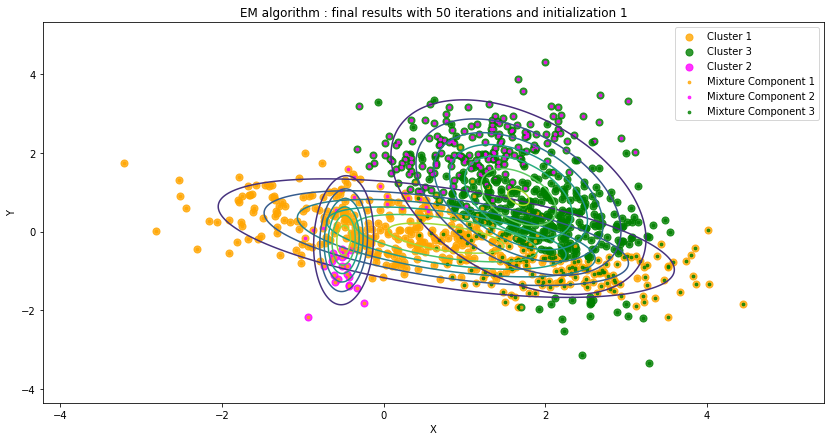

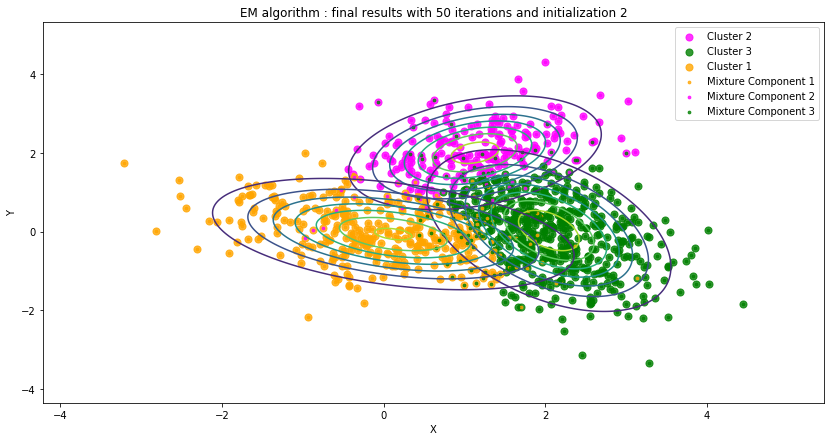

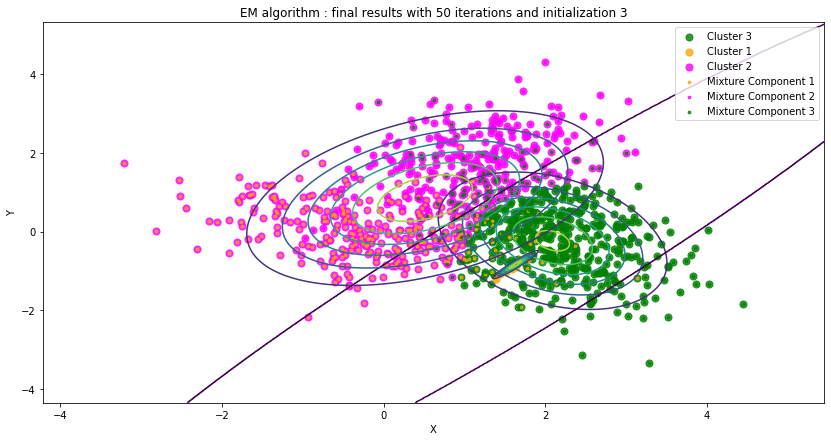

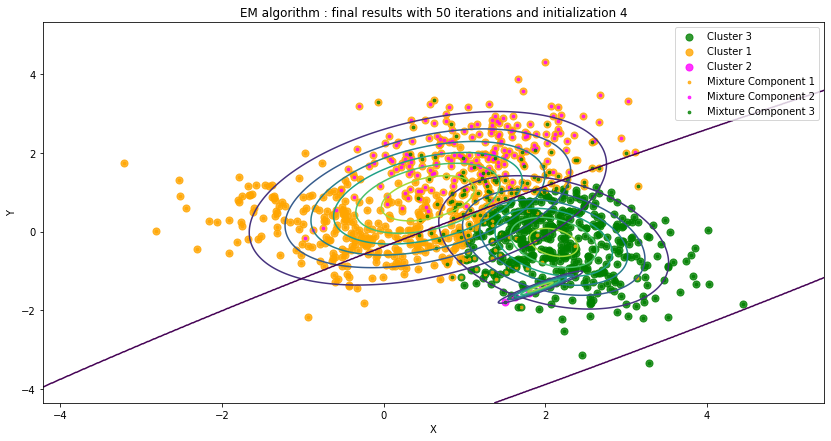

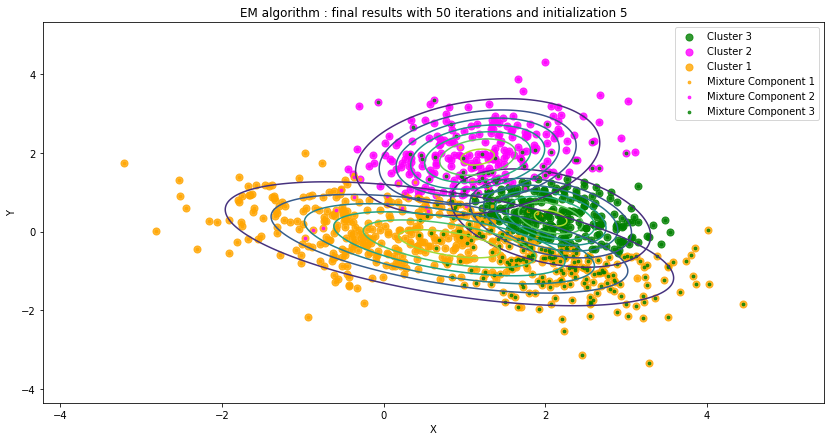

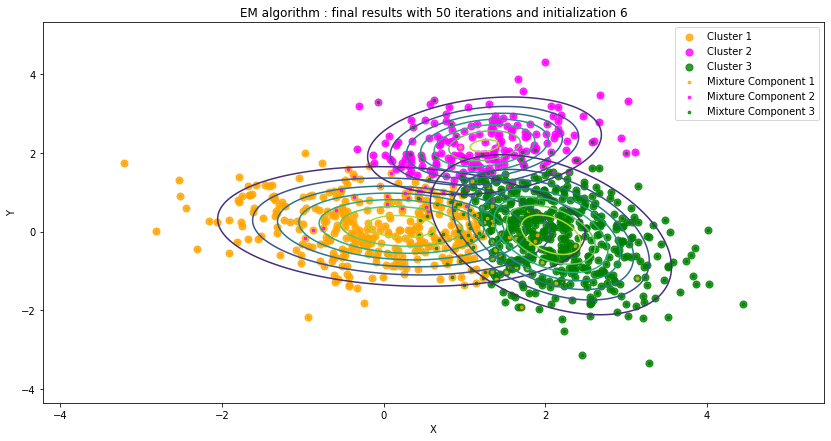

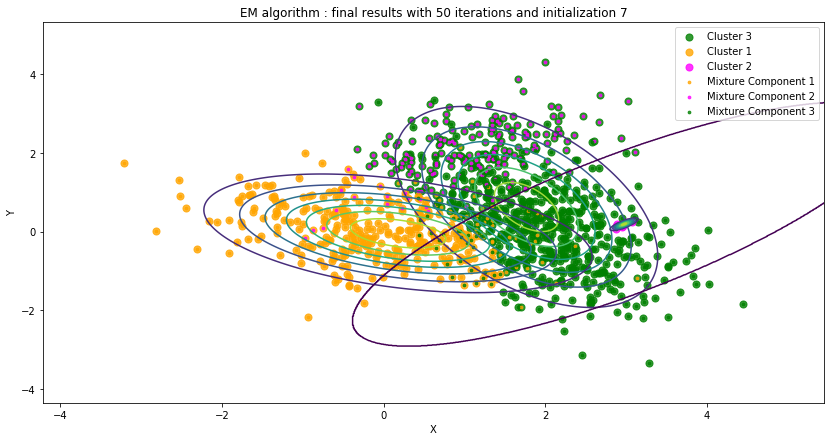

In [21]:
for i in range(7):
    nb_iterations = 50
    Ps, Mus, Sigmas, Lls = EM_GMM(nb_iterations, X, K)
    P_est = Ps[nb_iterations-1]
    Mu_est = Mus[nb_iterations-1]
    Sigma_est = Sigmas[nb_iterations-1]
    clusters = gamma_matrix(X, P_est, Mu_est, Sigma_est).argmax(axis=0)
    # Visualisation
    plt.figure(figsize=(14,7))
    plot_clusters(X, Mu_true, true_clusters, clusters, "EM algorithm : final results with 50 iterations and initialization " + str(i+1))
    plot_gaussian_contours(X, Mu_est, Sigma_est)
    plt.show()  

The EM algorithm is very sensitive to the initial values of the parameters. Although an EM iteration increases the log-likelihood function, it may converge to a local maximum likelihood, depending on those starting values. In that case, the resulting parameters at the end of the algorithm will not match the true parameters at all. It is also possible that one of the K clusters disappears with a bad initialization (i.e. no point will be matched to that cluster). However, if the initialization is valid, then we can see that in only 50 iterations, final clusters are close to the mixture components used to generate the dataset. Therefore we need to take care of initial parameters and in practice, we need to train our algorithm several times with different initial values to be sure to reach a global maximum likelihood.